## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [8]:
import import_ipynb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *

In [9]:
# Are  Midline and Edge already define in an excel file?
# Cyril's Note: For Schmidtea it's probably a better to perform a manual definition of the edge of the worm:
#         The segmentation is performed with the DIC 10x. As consequences:
#                 -> The edge of the worm where there is no centriole is included in the mask. In the Dev Cell, 2019, this zone was not taken into consideration
#                 -> It's always better (if possible) to use the 100x objective to draw the edge: there is chromatic aberration (not compensated so far) between 10x and 100x leading to mis calculation of the distance.
Load_Mid_and_Edge = True

# Are you just testing the angle compensation?
Test_Angle_Compensation = True

In [10]:
# Load Midline and Edge coordinates from a 'classical' excel file
if Load_Mid_and_Edge:
    path = './data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm'

    db = get_xls_values(path)

    x_mid = db['worm_midline']['x']
    y_mid = db['worm_midline']['y']
    x_edg = db['worm_edge']['x']
    y_edg = db['worm_edge']['y']

    newY_mid, newY_edg = [], []
    for y in y_mid:
        newY_mid.append(-y)

    for y in y_edg:
        newY_edg.append(-y)

# Automatic characterization of the midline and the edge
else:
    pass

./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm


In [11]:
#+++++++++++++++++++++++++++++
# TO DO
''' Adjust the midline with the edge of the worm'''

#+++++++++++++++++++++++++++++

# Reformat a midline and Edge in a given number of segment and subsegment
midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                       x_edg, newY_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

In [12]:
if Test_Angle_Compensation:
    # This step is usefull here to get a list of centriole already treated
    import xlrd  

    xls_name = "./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm"

    with xlrd.open_workbook(xls_name) as xls_file:
        # Go to appropriate sheet (index 0)
        xls_sheet = xls_file.sheet_by_index(0)

    a_list_of_centriole = []

    pixel_size = db['image_pixel_size_in_um']
    x_shift = db['image_shift']['x']
    y_shift = db['image_shift']['y']

    for row in range(xls_sheet.nrows - 7):
        if isinstance(xls_sheet.cell_value(row + 7, 3), (float, int)):
            X = xls_sheet.cell_value(row + 7, 3)/pixel_size + x_shift
            Y = -(xls_sheet.cell_value(row + 7, 4)/pixel_size + y_shift)
            angle = xls_sheet.cell_value(row + 7, 1)

            a_list_of_centriole.append(((X, Y), angle))
        
        
# Extraction of the centriole and analysis from an raw image
else:
    pass


 Idx | Angle |Lateral| Longi   || Marker | Color
------------------------------------------------
   1 |  -34  |  0.64 |  0.48   ||   o    | darkorange
 200 |  -22  |  0.40 |  0.49   ||   o    | darkviolet
 800 |   31  |  0.68 |  0.43   ||   o    | dodgerblue
 300 |  -17  |  0.16 |  0.46   ||   o    | crimson
 400 |    8  |  0.12 |  0.47   ||   o    | magenta
 500 |   29  |  0.39 |  0.44   ||   v    | darkorange
 600 |   12  |  0.56 |  0.43   ||   v    | darkviolet
 700 |   34  |  0.69 |  0.42   ||   v    | dodgerblue


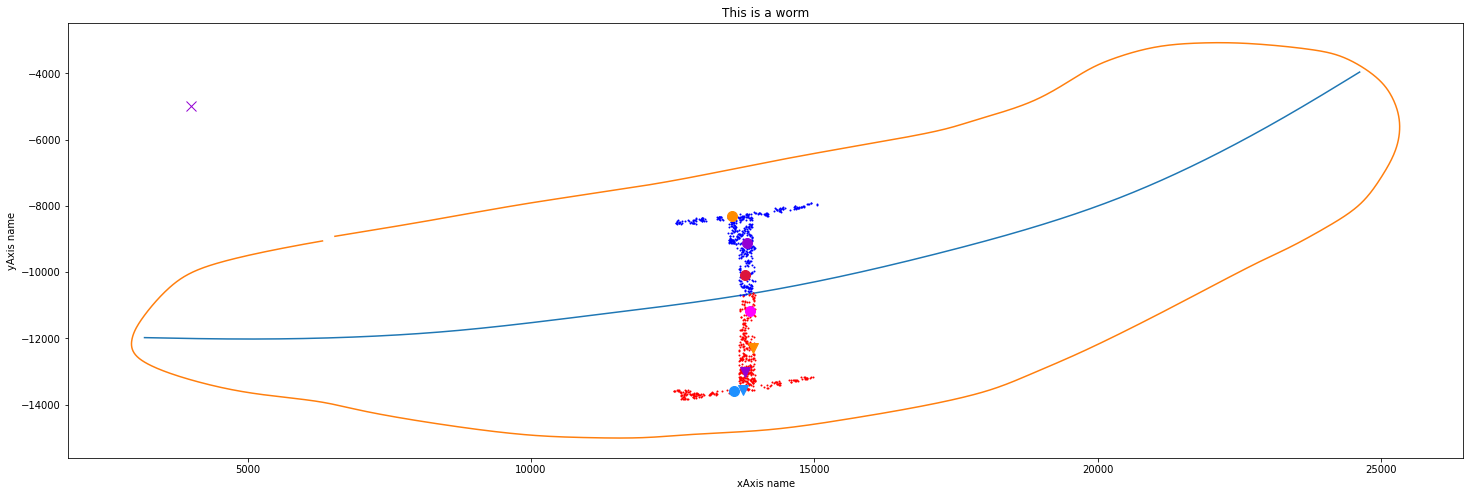

In [252]:


# Reformating of the centriole coordinates for graphical purpose
reoriented_centriole = []
for a_centriole in a_list_of_centriole:
    tmp_list = list(centriole_characterizator(a_centriole, midline_final))
    tmp_list.insert(1,a_centriole[0][0])
    tmp_list.insert(2,a_centriole[0][1])
    
    reoriented_centriole.append(tmp_list)

# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [1, 200, 800, 300, 400, 500, 600, 700]
#colors_ = ['g', 'm' ,'y']
colors_ = list(mcolors.TABLEAU_COLORS)
colors_ = ['darkorange', 'darkviolet', 'dodgerblue', 'crimson', 'magenta' ]
markers_ = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']


# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = 4000
Y_coordinate = -5000

plt.figure(figsize=(25,8))

# Plot Worm edge and midline
plt.plot(x_mid, newY_mid)
plt.plot(x_edg, newY_edg)

# Plot All centrioles
for z in reoriented_centriole:
    if z[5] == 'left':
        plt.plot(z[1], z[2], 'bo', markersize = 1)
    else:
        plt.plot(z[1], z[2], 'ro', markersize = 1)
        
# Plot centriole of interests
color_idx = 0
marker_idx = 0
if len(list_of_desired_centriole) !=0:
    print()
    #print(' {} | {} | {} |  {}  |  {} | {}'.format('Idx', 'Angle', 'Lateral', 'Longi', 'Marker',  'Color'))
    print(' {:^4}|{:^7}|{:^7}|{:^7}  ||{:^8}| {:<}'.format('Idx', 'Angle', 'Lateral', 'Longi', 'Marker',  'Color'))
    print('------------------------------------------------')
    for i in list_of_desired_centriole:
        plt.plot(reoriented_centriole[i][1], reoriented_centriole[i][2], color = colors_[color_idx], marker = markers_[marker_idx], markersize = 10)
        print('{:>4} |{:5.0f}  |{:6.2f} |{:6.2f}   ||{:^8s}| {}'.format(i, reoriented_centriole[i][8], reoriented_centriole[i][6], reoriented_centriole[i][7], markers_[marker_idx], colors_[color_idx]))
        if color_idx == (len(colors_)-1):
            color_idx = 0
            marker_idx +=1
            if marker_idx == len(markers_):
                marker_idx = 0
        else:
            color_idx +=1

        

# Plot a specific coordinate
if X_coordinate == None: 
    pass
else:
    plt.plot(X_coordinate, Y_coordinate, color = 'darkviolet', marker = 'x', markersize = 10)


plt.title('This is a worm')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [395]:
def print_a_antero_posterior_result(a_centriole_list, which_antero_posterior_segment, n_ante_post_segment = 5, a_lat_size = 0.2, a_lat_step = 0.05):
    ''' Function that print on a graph all the centriole that belong to an antero posterior segment'''
    
    moving_average = moving_average_angle(reoriented_centriole, 
                     a_lateral_size = a_lat_size, 
                     lat_step = a_lat_step, 
                     a_longitudinal_size = 1/n_ante_post_segment, 
                     long_step = 1/n_ante_post_segment)
    
    y_ma_values = moving_average[which_antero_posterior_segment]
    x_ma_values = np.linspace(a_lat_size/2, 1-a_lat_size/2, len(y_ma_values))
    
    longitudinal_ = which_antero_posterior_segment + 1
       
    plt.figure(figsize=(15,8))
    
    plt.plot(x_ma_values, y_ma_values)
    
    color_graph = ['orange', 'green', 'purple', 'cyan', 'blue']
    for a_centriole in a_centriole_list:
        if a_centriole[5] == 'left':
            lat = abs(a_centriole[6]-1)
        else: 
            lat = a_centriole[6] + 1
        
        if int(a_centriole[7]//(1/n_ante_post_segment) +1) == longitudinal_:
            plt.plot(lat/2, a_centriole[8], color = color_graph[which_antero_posterior_segment], marker = 'x', markersize = 1)


    plt.title('Individual centriole angle')
    plt.xlabel('Left side                   ||                  Right side')
    plt.ylabel('Centriole Angle')
    
    plt.ylim(-180, 180)
    plt.xlim(0,1)
    
    plt.xticks(np.arange(0, 1.01, step = 0.1))
    plt.yticks(np.arange(-180, 181, step=30))
    
    plt.grid(axis ='y', linestyle='--', linewidth=0.5)
    plt.vlines(x = 0.5, ymin = -180, ymax = 180,  linestyle='--', linewidth=0.5, color ='r')
    
    plt.show()

In [394]:

# Maybe I can Add a "90% of the centriole limit" or something like that
def moving_average_angle(a_centriole_list, a_lateral_size, lat_step, a_longitudinal_size = 0.2, long_step = 0.2):
    # Verification of 'perfect' lateral parameters
    n_lat_segment = int(  (1/lat_step) - (a_lateral_size/lat_step) +1)
    if  n_lat_segment != (1/lat_step-a_lateral_size/lat_step +1):
        print('Your parameters do not allow to cover the laterality of the worm equally (the last segment is not equal to all the other and will not be calculated)')
        print(n_lat_segment, 1/lat_step-a_lateral_size/lat_step)
    
    # Verification of 'perfect' longitudinal parameters  
    n_long_segment = int(1/long_step-a_longitudinal_size/long_step) + 1
    if  n_long_segment != (1/long_step-a_longitudinal_size/long_step + 1):
        print('Your parameters do not allow to cover the length of the worm equally (the last segment is not equal to all the other and will not be calculated)')
    
    # Table instantiation
    counter = np.zeros((n_long_segment, n_lat_segment))
    cos_sum = np.zeros((n_long_segment, n_lat_segment))
    sin_sum = np.zeros((n_long_segment, n_lat_segment))
    
    # Iterate thourh each centriole of the list
    for a_centriole in a_centriole_list:
        # Recalculate the lateral distance (left = 0, right = 1)
        if a_centriole[5] == 'left':
            lat_ctrl = abs(a_centriole[6]-1)
        else: 
            lat_ctrl = a_centriole[6] + 1
        
        lat_ctrl = lat_ctrl/2
        lon_ctrl = a_centriole[7]
        
        # Does the centriole belong to this longitudinal segment?
        for long_ in range(n_long_segment):
            if (0 + long_step*long_) <= lon_ctrl <= (a_longitudinal_size+long_step*long_):
                
                # if YES, Does the centriole belong to this longitudinal segment?
                for lat_ in range(n_lat_segment):
                    if (0+lat_step*lat_) <= lat_ctrl <= (a_lateral_size+lat_step*lat_):
                        
                        # if YES, modifiy, counter and sum cos and sin in appropriate position
                        counter[long_][lat_] += 1
                        cos_sum[long_][lat_] += math.cos(math.radians(a_centriole[8]))
                        sin_sum[long_][lat_] += math.sin(math.radians(a_centriole[8]))
    
    
    print(f'Analysis computed on {n_long_segment} Antero_posterior segment and {n_lat_segment} Medio-lateral segment')
    
    # if count = 0 => Divsion by 0
    # replace all the count = 0 by count = 1 to be able to compute the angle average
    # since if count = 0, angle = 0 , the result is not affected BUT final table is false (0 should be replace by NAN)
    counter = np.reshape([1 if ele == 0 else ele for ele in  counter.flatten()], (n_long_segment, n_lat_segment))

    cos_mean = cos_sum/counter   
    sin_mean = sin_sum/counter
    angle_mean = np.degrees(np.arctan2(sin_mean, cos_mean))
    
    return angle_mean

Analysis computed on 5 Antero_posterior segment and 17 Medio-lateral segment


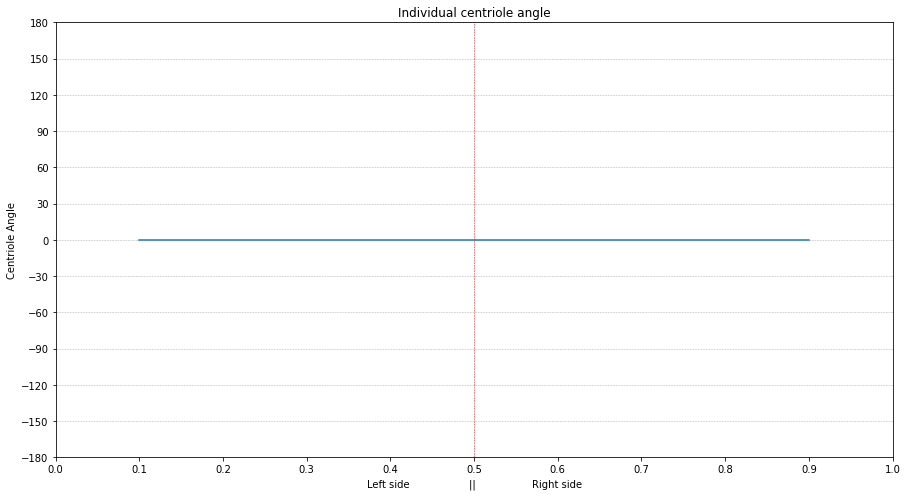

Analysis computed on 5 Antero_posterior segment and 17 Medio-lateral segment


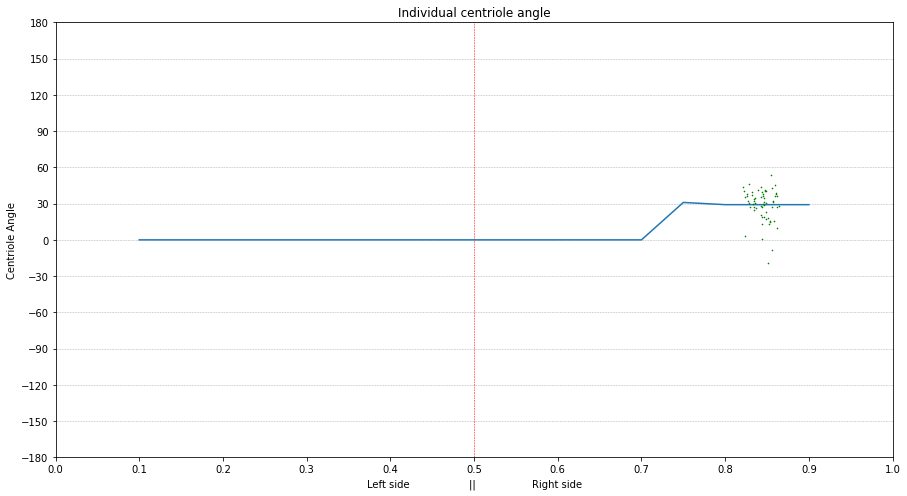

Analysis computed on 5 Antero_posterior segment and 17 Medio-lateral segment


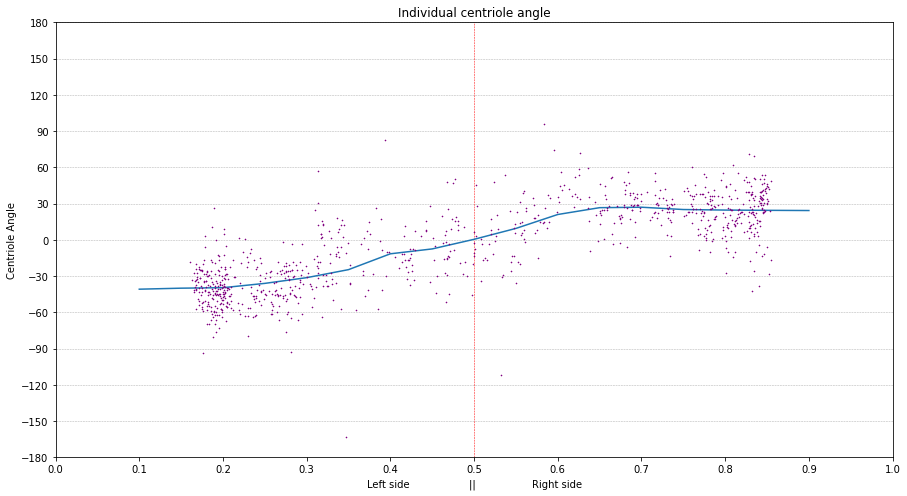

Analysis computed on 5 Antero_posterior segment and 17 Medio-lateral segment


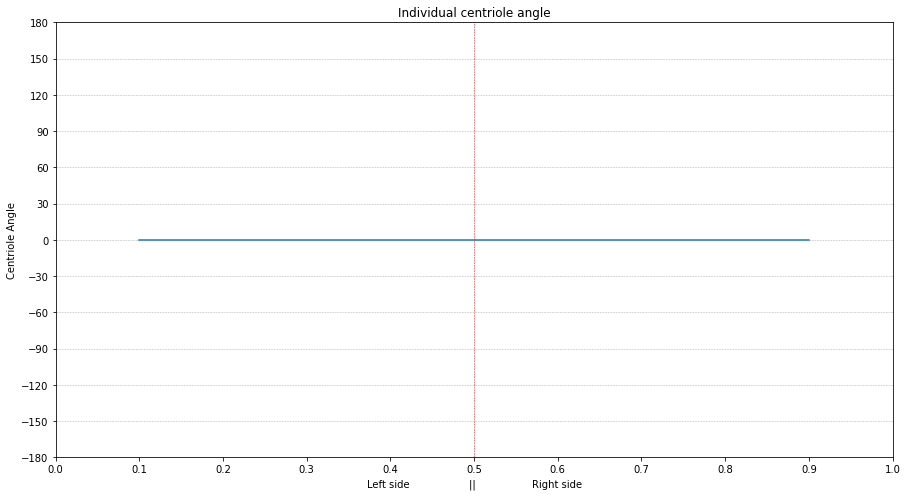

Analysis computed on 5 Antero_posterior segment and 17 Medio-lateral segment


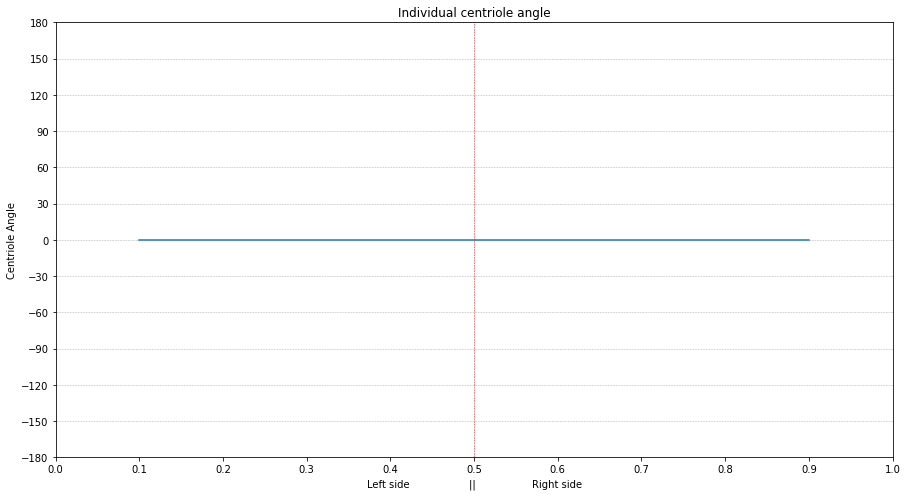

In [397]:
# Graphical representation of the results 

for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.2, a_lat_step = 0.05)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0. 29.  0.  0.  0.  0.  0.  0.  0.  0.]
[  0.  24.  25.  30.  10.  -8. -15. -39. -41.   0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


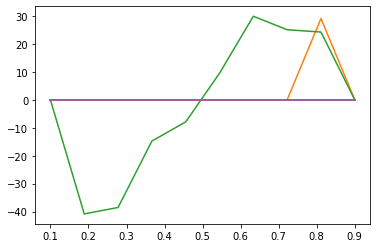

In [224]:
# Plot the mean
np.set_printoptions(precision=0)
for i in mean_angle:
    plt.plot(np.linspace(0.9, 0.1, 10), i)
    
plt.show()